In [3]:
import h5py
import numpy as np
from dataset.local_shape_descriptor import get_local_shape_descriptors
from time import time
from dataset.utils import from_h5

%load_ext autoreload
%autoreload 2

In [2]:
hf = h5py.File('./data/cremi/sample_A.hdf', 'r')
print('volA resolution:', hf['volumes']['raw'].attrs.get('resolution'))
hf = h5py.File('./data/cremi/sample_B.hdf', 'r')
print('volB resolution:', hf['volumes']['raw'].attrs.get('resolution'))
hf = h5py.File('./data/cremi/sample_C.hdf', 'r')
print('volC resolution:', hf['volumes']['raw'].attrs.get('resolution'))

volA resolution: [40.  4.  4.]
volB resolution: [40.  4.  4.]
volC resolution: [40.  4.  4.]


In [5]:
import matplotlib.pyplot as plt

def vis_lsd(lsd, i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(1,4)
    fig.set_size_inches(24, 6)
    lsd1 =  np.moveaxis(lsd[0:3, i ,: ,:],0,2)
    lsd2 =  np.moveaxis(lsd[3:6, i ,: ,:],0,2)
    lsd3 =  np.moveaxis(lsd[6:9, i ,: ,:],0,2)
    lsd4 =  lsd[9, i ,: ,:]
    axarr[0].imshow(lsd1)
    axarr[1].imshow(lsd2)
    axarr[2].imshow(lsd3)
    axarr[3].imshow(lsd4, cmap='jet')
    plt.show()


In [1]:
from dataset.utils import from_h5
from dataset.local_shape_descriptor import get_local_shape_descriptors

label = from_h5(f'./data/cremi/sample_B.hdf', dataset_path='volumes/labels/neuron_ids')

100%|██████████| 18/18 [00:00<00:00, 31.02it/s]


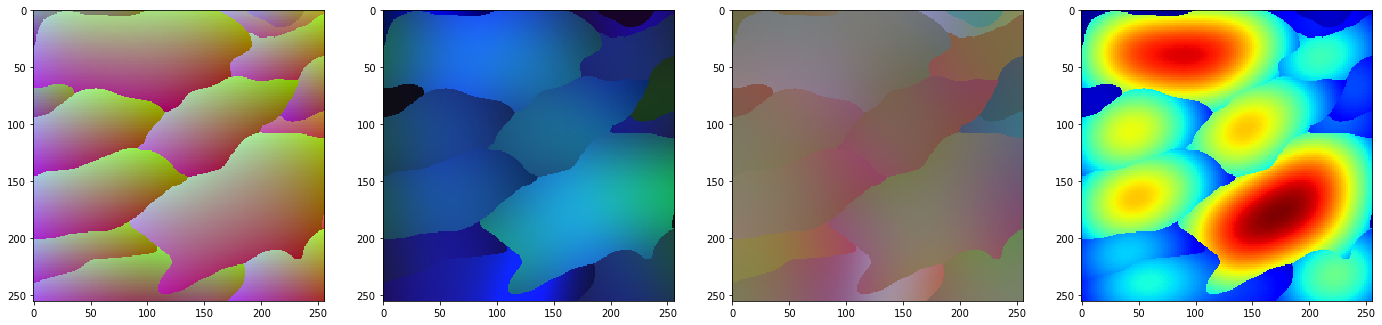

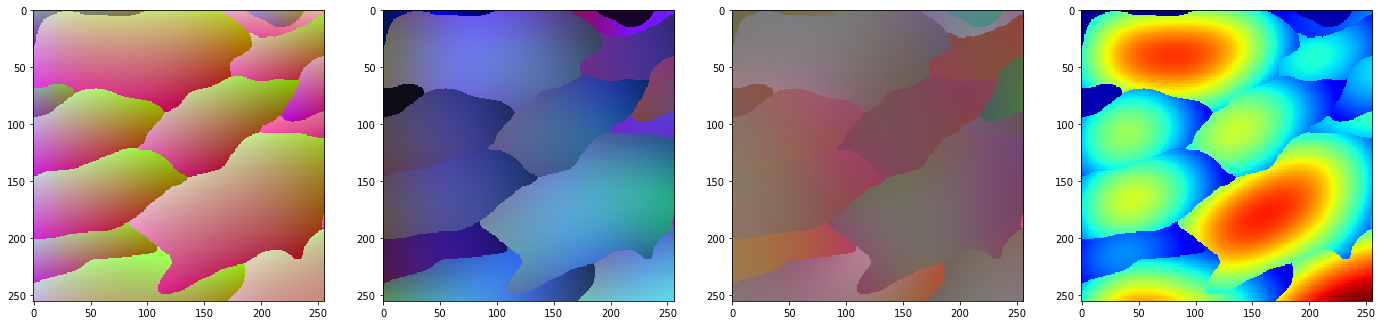

In [6]:
sigma = (3, 30, 30)
downsample = 2 # downsample factor of as in LSD paper (pg. 20)

sz = 256
label_chunk = label[0:4,0:sz,0:sz]
lsd_compute = get_local_shape_descriptors(label_chunk, sigma, downsample=downsample, num_threads=8)

lsd_load = np.load('./data/cremi/sample_B_lsd.npy')
lsd_load = lsd_load[:,0:4,0:sz,0:sz]
vis_lsd(lsd_compute)
vis_lsd(lsd_load)

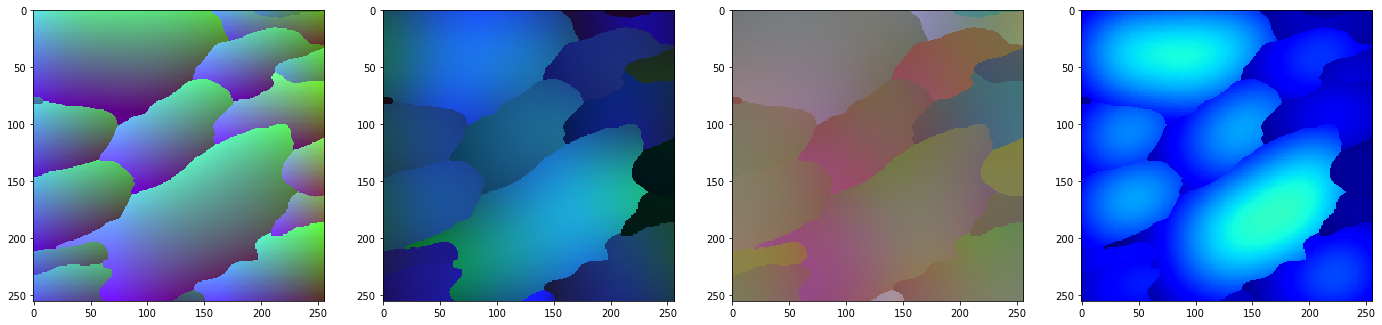

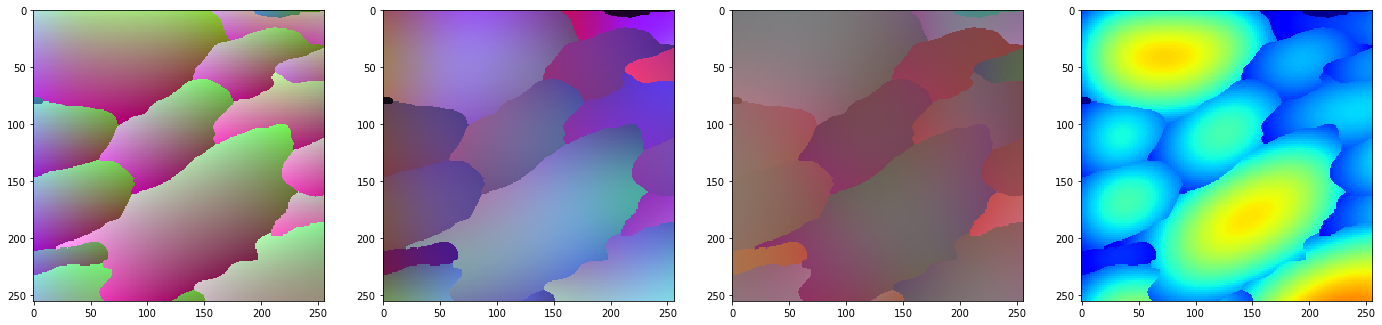

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


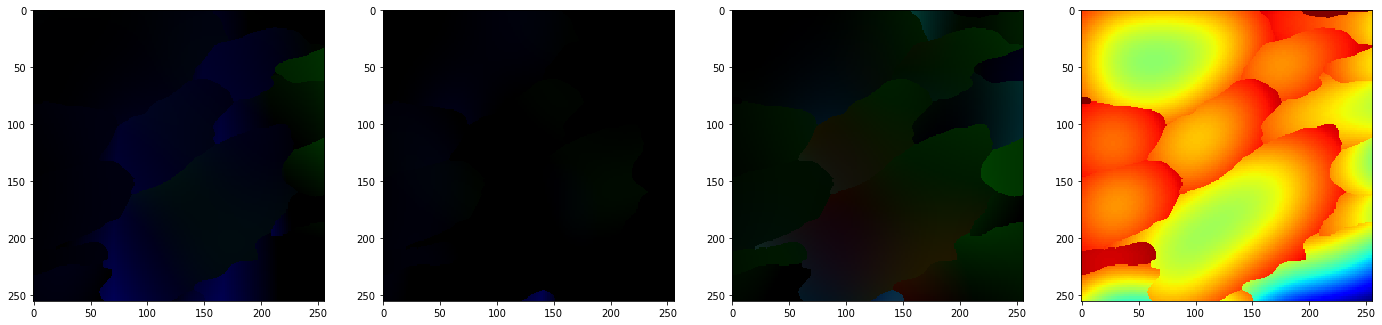

In [11]:
vis_lsd(lsd_compute,i=-1)
vis_lsd(lsd_load,i=-1)
vis_lsd(lsd_compute-lsd_load,i=-1)